In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate noise-free and noise-affected networks

In [3]:
seed = 666
n_nets = 2000
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = int(n_nets*.5)
noise_level = .5
noise_sd = .05

In [4]:
sim_nets, noisy_nets, noises, noise_ids = simulate_networks(n_nets=n_nets, n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=seed,
                                          n_noisy_nets=n_noisy_nets, noise_level=noise_level, noise_sd=noise_sd)
print(sim_nets.shape, noisy_nets.shape, noises.shape)

(2000, 68, 68) (2000, 68, 68) (2000,)


In [5]:
# PCA projections of noise-free and noise-affected networks for visualizations

pca = PCA(2)
sim_Xt = pca.fit_transform(sim_nets.reshape(-1, n_nodes*n_nodes))
noisy_Xt = pca.fit_transform(noisy_nets.reshape(-1, n_nodes*n_nodes))
sim_df = pd.DataFrame({"pc1": sim_Xt[:,0], "pc2": sim_Xt[:,1], "noise": noises})
noisy_df = pd.DataFrame({"pc1": noisy_Xt[:,0], "pc2": noisy_Xt[:,1], "noise": noises})

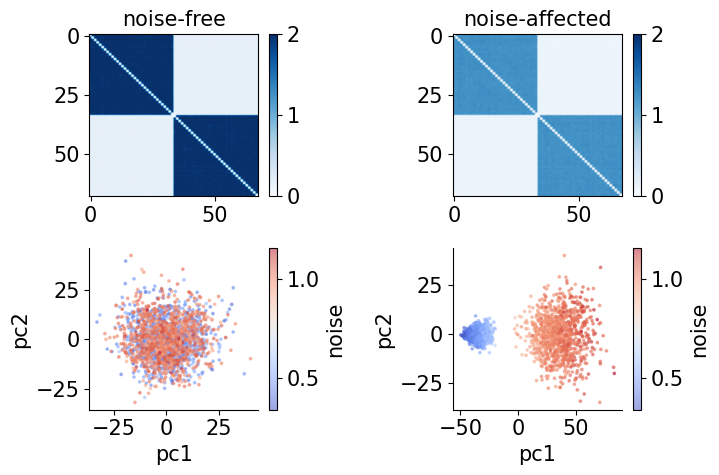

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(7.5, 5))

p1 = axes[0,0].imshow(sim_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,0].set_title('noise-free')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[0,1].imshow(noisy_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,1].set_title('noise-affected')
cbar = plt.colorbar(p2, ax=axes[0,1])

p3 = axes[1,0].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=sim_df, s=3, alpha=0.5)
axes[1,0].set_xlabel('pc1')
axes[1,0].set_ylabel('pc2')
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1,0], label="noise")

p4 = axes[1,1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=noisy_df, s=3, alpha=0.5)
axes[1,1].set_xlabel('pc1')
axes[1,1].set_ylabel('pc2')
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
cbar = plt.colorbar(p4, ax=axes[1,1], label="noise")

plt.tight_layout()

prepare torch datasets for training

In [41]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.0,
    alpha = 1, beta = 1., gamma = 1, add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=100, lr=1e-4, device=DEVICE)

In [42]:
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(noisy_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

1800 200


In [9]:
# create masks for graph convolution layers

A_mat = np.mean(noisy_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [43]:
model = VAE(config).to(config.device)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [44]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 3143.734 nll: 3142.914 kl: 0.820
epoch: 0 test loss 2982.484 nll: 2981.823 kl: 0.661
epoch: 5 train loss: 2627.786 nll: 2549.557 kl: 78.229
epoch: 5 test loss 2618.272 nll: 2547.172 kl: 71.100
epoch: 10 train loss: 2488.263 nll: 2427.247 kl: 61.016
epoch: 10 test loss 2505.191 nll: 2449.125 kl: 56.065
epoch: 15 train loss: 2464.078 nll: 2414.424 kl: 49.655
epoch: 15 test loss 2495.162 nll: 2441.969 kl: 53.193
epoch: 20 train loss: 2481.220 nll: 2433.939 kl: 47.281
epoch: 20 test loss 2484.163 nll: 2439.382 kl: 44.780
epoch: 25 train loss: 2445.615 nll: 2404.065 kl: 41.550
epoch: 25 test loss 2462.220 nll: 2423.721 kl: 38.500
epoch: 30 train loss: 2437.604 nll: 2400.141 kl: 37.463
epoch: 30 test loss 2468.832 nll: 2433.766 kl: 35.066
epoch: 35 train loss: 2435.218 nll: 2400.004 kl: 35.214
epoch: 35 test loss 2458.964 nll: 2426.710 kl: 32.254
epoch: 40 train loss: 2429.210 nll: 2396.647 kl: 32.563
epoch: 40 test loss 2463.922 nll: 2434.524 kl: 29.397
epoch: 45 train 

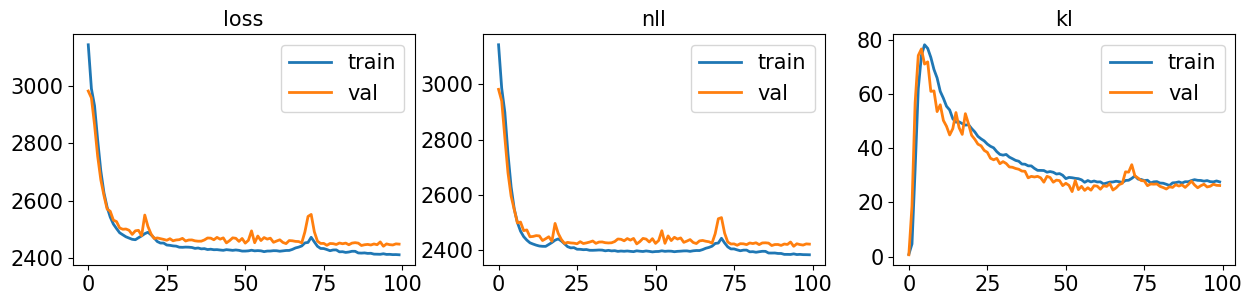

In [45]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.show()

In [46]:
# torch.save(model.state_dict(), './pretrained/sim_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_vae_pretrained.mod'))

In [47]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

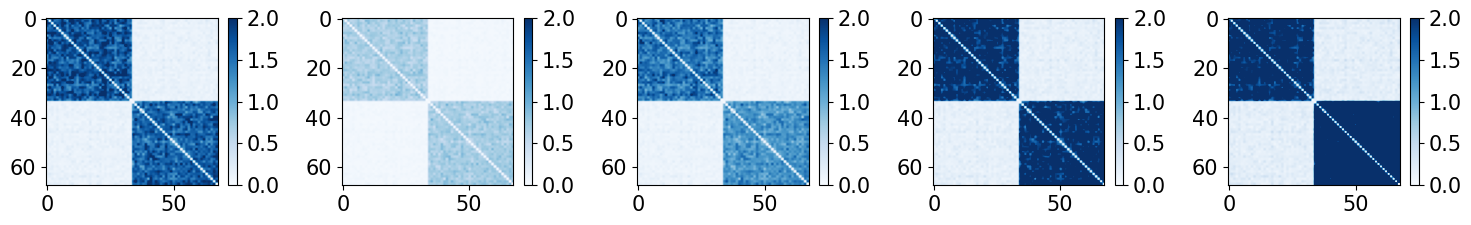

In [48]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [49]:
pca = PCA(2)
vae_Xt = pca.fit_transform(vae_latents)
vae_df = pd.DataFrame({"pc1": vae_Xt[:,0], "pc2": vae_Xt[:,1], "noise": noises})

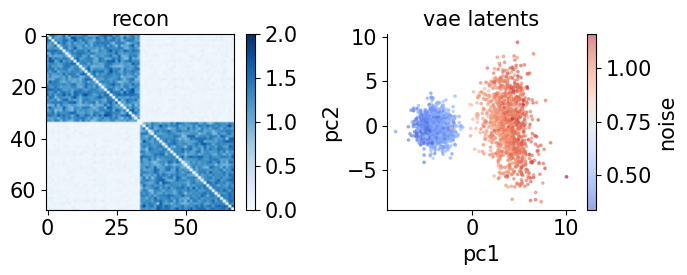

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

p1 = axes[0].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('recon')
cbar = plt.colorbar(p1, ax=axes[0])

p3 = axes[1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=vae_df, s=3, alpha=0.5)
axes[1].set_xlabel('pc1')
axes[1].set_ylabel('pc2')
axes[1].set_title('vae latents')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1], label="noise")

plt.tight_layout()

inv_vae

In [31]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1., beta = 1., gamma = 10., add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=100, lr=1e-4, device=DEVICE)

In [32]:
inv_model = INV_VAE(config).to(config.device)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [33]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.custom_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.custom_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 3148.688 nll: 3147.579 kl: 0.860 inv_loss: 0.025
epoch: 0 test loss 3005.116 nll: 3003.585 kl: 1.274 inv_loss: 0.026
epoch: 5 train loss: 2594.115 nll: 2513.108 kl: 68.135 inv_loss: 1.287
epoch: 5 test loss 2630.467 nll: 2563.217 kl: 56.804 inv_loss: 1.045
epoch: 10 train loss: 2482.401 nll: 2419.906 kl: 50.923 inv_loss: 1.157
epoch: 10 test loss 2526.001 nll: 2466.118 kl: 49.143 inv_loss: 1.074
epoch: 15 train loss: 2457.514 nll: 2407.488 kl: 39.817 inv_loss: 1.021
epoch: 15 test loss 2515.588 nll: 2469.162 kl: 37.286 inv_loss: 0.914
epoch: 20 train loss: 2447.274 nll: 2403.092 kl: 34.169 inv_loss: 1.001
epoch: 20 test loss 2507.373 nll: 2463.391 kl: 34.368 inv_loss: 0.961
epoch: 25 train loss: 2447.086 nll: 2406.007 kl: 31.421 inv_loss: 0.966
epoch: 25 test loss 2529.100 nll: 2493.558 kl: 27.524 inv_loss: 0.802
epoch: 30 train loss: 2452.666 nll: 2414.199 kl: 29.093 inv_loss: 0.937
epoch: 30 test loss 2498.758 nll: 2457.704 kl: 31.146 inv_loss: 0.991
epoch: 35 tr

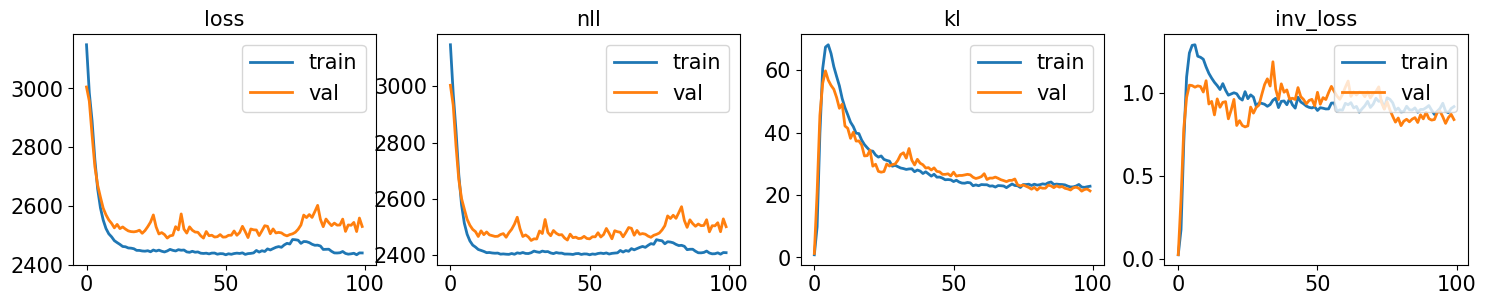

In [34]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.show()

In [35]:
# torch.save(inv_model.state_dict(), './pretrained/sim_inv_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_inv_vae_pretrained.mod'))

In [36]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_recon = inv_model.decode(z_sample, 
                      tensor_noises.to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = inv_model.decode(z_sample, 
                      torch.ones_like(tensor_noises).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

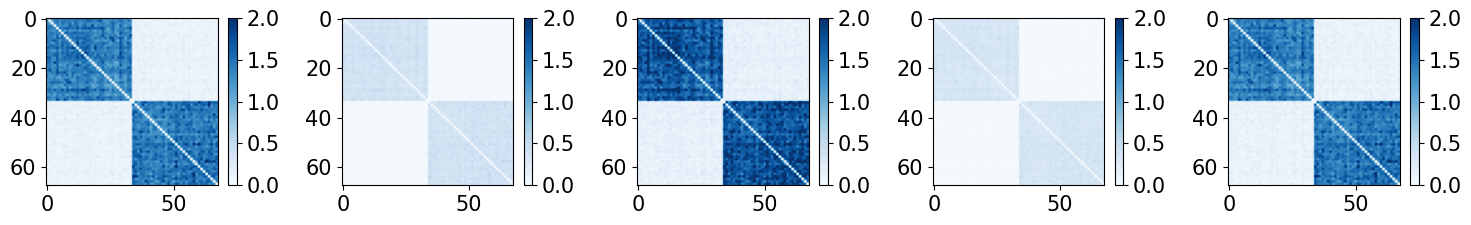

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

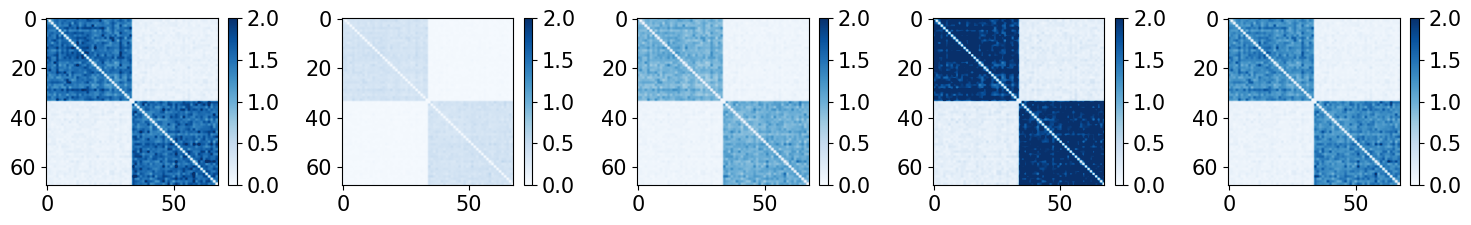

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [39]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(inv_latents)
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

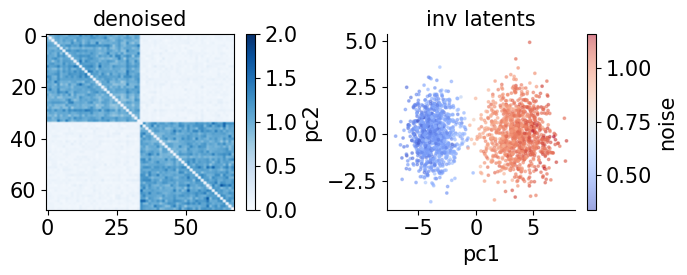

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

p1 = axes[0].imshow(x_denoised.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('denoised')
cbar = plt.colorbar(p1, ax=axes[0])

p3 = axes[1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=inv_vae_df, s=3, alpha=0.5)
axes[1].set_xlabel('pc1')
axes[1].set_ylabel('pc2')
axes[1].set_title('inv latents')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[1], label="noise")

plt.tight_layout()